<a href="https://colab.research.google.com/github/HumeraF2/AML-Assignment/blob/main/aml_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/credit_card_churn.csv")

In [ ]:
print(df.info(),'\n')
print(df.head(),'\n')
print(df.describe(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.0,7.391776e+08,3.690378e+07,708082083.0,713036770.5,717926358.0,773143533.0,828343083.0
Customer_Age,10127.0,4.632596e+01,8.016814e+00,26.0,41.0,46.0,52.0,73.0
Dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.0,2.0,3.0,5.0
Months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,31.0,36.0,40.0,56.0
Total_Relationship_Count,10127.0,3.812580e+00,1.554408e+00,1.0,3.0,4.0,5.0,6.0
Months_Inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.0,2.0,3.0,6.0
Contacts_Count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.0,2.0,3.0,6.0
Credit_Limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2555.0,4549.0,11067.5,34516.0
Total_Revolving_Bal,10127.0,1.162814e+03,8.149873e+02,0.0,359.0,1276.0,1784.0,2517.0
Avg_Open_To_Buy,10127.0,7.469140e+03,9.090685e+03,3.0,1324.5,3474.0,9859.0,34516.0


In [ ]:
#Check for missing values
df.isnull().sum()

In [ ]:
#Calculate summary statistics for categorical data
for col in df.select_dtypes(include='object').columns:
    print(f"{col}:\n{df[col].value_counts()}\n")

In [ ]:
#Drop unnecessary features
df.drop(['CLIENTNUM','Marital_Status', 'Education_Level'], axis=1, inplace=True)
df.info()

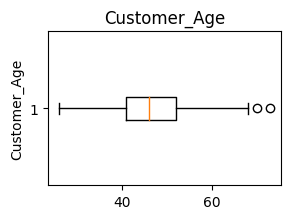

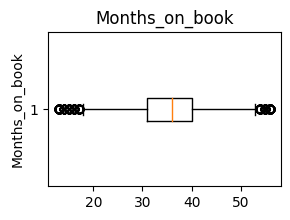

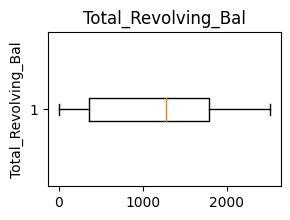

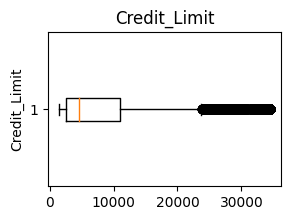

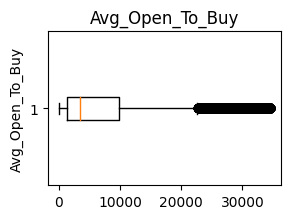

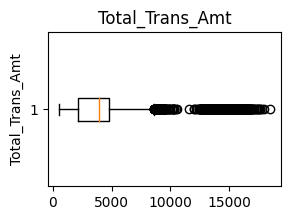

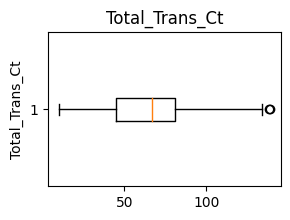

In [ ]:
#Display Multiple Boxplots to identify any outliers
import matplotlib.pyplot as plt

columns = ['Customer_Age', 'Months_on_book','Total_Revolving_Bal','Credit_Limit','Avg_Open_To_Buy','Total_Trans_Amt', 'Total_Trans_Ct']
for col in columns:
  plt.boxplot(df[col],vert=False)
  plt.title(col)
  plt.ylabel(col)
  plt.rcParams["figure.figsize"] = (3,2)
  plt.show()
 

In [ ]:
#** Removing Outliers: To remove outliers, use a method like Z-score or IQR to detect and remove the extreme values. **
from scipy import stats
import scipy.stats as stats

# Calculate Z-scores and retain rows with Z-score greater than -3 or less than +3

z_scores = stats.zscore(df['Customer_Age'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Age')
plt.ylabel('Customer_Age')
plt.rcParams["figure.figsize"] = (3,2)
plt.show()

z_scores = stats.zscore(df['Months_on_book'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Months_on_book')
plt.ylabel('Months on Book')
plt.show()

z_scores = stats.zscore(df['Total_Trans_Ct'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Total Transaction Ct')
plt.ylabel('Total Transaction Ct')
plt.show()

z_scores = stats.zscore(df['Credit_Limit'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Credit Limit')
plt.ylabel('Credit Limit')
plt.show()

z_scores = stats.zscore(df['Avg_Open_To_Buy'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Avg Open To Buy')
plt.ylabel('Avg Open To Buy')
plt.show()

z_scores = stats.zscore(df['Total_Trans_Amt'])
plt.boxplot(z_scores,vert=False)
df = df[(z_scores >= -3) & (z_scores <= 3)]
plt.title('Box plot of Total Transanction Amt')
plt.ylabel('Total Transanction Amt')
plt.show()


In [ ]:
#Display the box plot again

columns = ['Customer_Age', 'Months_on_book','Credit_Limit','Avg_Open_To_Buy','Total_Trans_Amt', 'Total_Trans_Ct']
for col in columns:
  plt.boxplot(df[col],vert=False)
  plt.title(col)
  plt.ylabel(col)
  plt.rcParams["figure.figsize"] = (3,2)
  plt.show()


In [ ]:
#Convert the categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=False)
df.info()

In [ ]:
df.drop(['Attrition_Flag_Attrited Customer','Income_Category_Unknown', 'Card_Category_Silver'], axis=1, inplace=True)

In [ ]:
#Standardisation
from sklearn.preprocessing import StandardScaler
  
# Separate the dummy variables from the numerical variables
dummy_cols = df.select_dtypes(include='uint8').columns
num_cols = list(set(df.select_dtypes(include=['float64', 'int64']).columns) - set(dummy_cols))

# Standardize the numerical variables
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Combine the standardized numerical variables with the dummy variables
df_std = pd.concat([df[num_cols], df[dummy_cols]], axis=1)

print(df_std.head(5),'\n')
print(df_std.describe(),'\n')

In [ ]:
print(df.columns)

In [ ]:
#Split the data into training and test sets (70:30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_std.drop('Attrition_Flag_Existing Customer', axis=1), df['Attrition_Flag_Existing Customer'], test_size=0.3, random_state=50)

In [ ]:
#Import/install the necessary packages
!pip install scikeras
import scikeras as sk
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense (21, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model   

# create the model
model = KerasRegressor(build_fn=create_model, verbose=0, )
print(model)

In [ ]:
# define the grid search parameters
param_grid = {'batch_size': [32, 64],
              'epochs': [50,100],
              'optimizer': ['adam', 'sgd']}


# perform grid search to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
 
# print the best parameters
print(f"Best Parameters: {grid_result.best_params_}")

In [ ]:
#Fit the model with the best hyperparameters and make predictions using the test set
best_model = grid.best_estimator_
best_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], verbose=0, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Y predict on X test set
y_pred = best_model.predict(X_test)

In [ ]:
#Display Feature Importance

importance = best_model.predict(X_train, verbose=0)
importance = np.squeeze(importance)
feature_names = X_train.columns
feature_importance = dict(zip(feature_names, importance))
sorted_importance = sorted(feature_importance.items(), key=lambda kv: abs(kv[1]), reverse=True)

for feature, importance in sorted_importance:
    print(f"{feature}: {abs(importance)}")

importance_values = [abs(kv[1]) for kv in sorted_importance]
#print(importance_values)
feature_names = [kv[0] for kv in sorted_importance]
#print(feature_names)
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(range(len(importance_values)), importance_values, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [ ]:
#predict the churn values
print(y_pred)
# unscaling the y_pred values 
y_pred_lis = []
for i in y_pred:
    if i>0.5:
        y_pred_lis.append(1)
    else:
        y_pred_lis.append(0)
print(y_pred_lis)

In [ ]:
#make dataframe for comparing the orignal and predict values
data = {'orignal_churn':y_test, 'predicted_churn':y_pred_lis}
df_check = pd.DataFrame(data)
df_check.head(10)

In [ ]:
# checking for performance metrices, importing classification_report and confusion metrics
import seaborn as sb
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

#print classification_report
print(classification_report(y_test, y_pred_lis))

# ploting the confusion metrix plot
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_lis)
plt.figure(figsize = (10,5))
sb.heatmap(conf_mat, annot=True,fmt='d',)
plt.xlabel('Predicted_number')
plt.ylabel('True_number')

In [ ]:
#Roc and auc curves
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, y_pred)
false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)

plt.figure(figsize=(6, 4), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()